### Download dataset

In [1]:
import kagglehub
import pandas as pd, numpy as np, re, ast
from tqdm.auto import tqdm
tqdm.pandas()

path = kagglehub.dataset_download("artermiloff/steam-games-dataset")

print("Path to dataset files:", path)

/Users/mihkeljarviste/PycharmProjects/steam_semantic_recommender/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Path to dataset files: /Users/mihkeljarviste/.cache/kagglehub/datasets/artermiloff/steam-games-dataset/versions/2


### Display dataset

In [2]:
import pandas as pd
games = pd.read_csv(f"{path}/games_march2025_cleaned.csv")

print(games.shape)
games.head(3).T

(89618, 47)


,0,1,2
appid,730,578080,570
name,Counter-Strike 2,PUBG: BATTLEGROUNDS,Dota 2
release_date,2012-08-21,2017-12-21,2013-07-09
required_age,0,0,0
price,0.0,0.0,0.0
dlc_count,1,0,2
detailed_description,"For over two decades, Counter-Strike has offer...","LAND, LOOT, SURVIVE! Play PUBG: BATTLEGROUNDS ...","The most-played game on Steam. Every day, mill..."
about_the_game,"For over two decades, Counter-Strike has offer...","LAND, LOOT, SURVIVE! Play PUBG: BATTLEGROUNDS ...","The most-played game on Steam. Every day, mill..."
short_description,"For over two decades, Counter-Strike has offer...",Play PUBG: BATTLEGROUNDS for free. Land on str...,"Every day, millions of players worldwide enter..."
reviews,NaN,NaN,“A modern multiplayer masterpiece.” 9.5/10 – D...


### Minimal Dataset Features We Keep

In [3]:
KEEP = [
    'appid',
    'name',
    'release_date',
    'price',
    'header_image',
    # our new popularity signals
    'estimated_owners',
    'peak_ccu',
    # user-feedback
    'positive',
    'negative',
    'num_reviews_total',
    # text for the semantic model
    'detailed_description',
    'short_description',
    # rich metadata
    'genres',
    'categories',
    'tags'
]
df = games[KEEP].copy()

### Drop games with short descriptions

In [4]:
df['detailed_word_count'] = df['detailed_description'].str.split().str.len()
df = df[df['detailed_word_count'] >= 35].reset_index(drop=True)
print(f"After trimming short descriptions: {df.shape[0]} titles remain")

After trimming short descriptions: 87502 titles remain


### Filter to English and TOP 5000 in popularity

In [5]:

import pandas as pd
from langdetect import detect

df['detailed_description'] = df['detailed_description'].fillna('').astype(str)
df = df[df['detailed_description']
            .apply(lambda txt: len(txt.split()) >= 35)
        ].reset_index(drop=True)

pop_cols = ['estimated_owners', 'peak_ccu', 'num_reviews_total']
df[pop_cols] = (
    df[pop_cols]
      .apply(pd.to_numeric, errors='coerce')
      .fillna(0)
)

df = df[df['num_reviews_total'] >= 313].reset_index(drop=True)

pop_est = df['estimated_owners']
pop_ccu = df['peak_ccu']
pop_rev = df['num_reviews_total']

df['popularity'] = pop_est.where(pop_est > 0,
                         pop_ccu.where(pop_ccu > 0,
                                       pop_rev))

df = df[df['popularity'] > 0].reset_index(drop=True)

def is_english(text: str) -> bool:
    try:
        return detect(text) == 'en'
    except:
        return False

df = (
    df.sort_values('popularity', ascending=False)
      .head(7_000)
      .reset_index(drop=True)
)
df = df[df['detailed_description'].apply(is_english)].reset_index(drop=True)

df = (
    df.sort_values('popularity', ascending=False)
      .head(5_000)
      .reset_index(drop=True)
)

print("Final shape:", df.shape)


Final shape: (5000, 17)


In [6]:
df[df['name'] == "Counter-Strike 2"]

,appid,name,release_date,price,header_image,estimated_owners,peak_ccu,positive,negative,num_reviews_total,detailed_description,short_description,genres,categories,tags,detailed_word_count,popularity
0,730,Counter-Strike 2,2012-08-21,0.0,https://shared.akamai.steamstatic.com/store_it...,0.0,1212356,7480813,1135108,8632939,"For over two decades, Counter-Strike has offer...","For over two decades, Counter-Strike has offer...","['Action', 'Free To Play']","['Multi-player', 'Cross-Platform Multiplayer',...","{'FPS': 90857, 'Shooter': 65397, 'Multiplayer'...",127.0,1212356.0


### IMDb-style weighted rating

In [7]:

df["total_votes"] = df["positive"] + df["negative"]
df["pct_positive"] = df["positive"] / df["total_votes"].replace(0, np.nan)

C = df["pct_positive"].mean()  # global avg positivity
m = df["total_votes"].quantile(0.60)  # 60-th vote percentile

df["weighted_score"] = (
        (df["total_votes"] / (df["total_votes"] + m) * df["pct_positive"]) +
        (m / (df["total_votes"] + m) * C)
).fillna(0)

# **Normalise to 0-1 here so every subsequent cell can rely on it**
df["normalized_rating"] = (
                                  df["weighted_score"] - df["weighted_score"].min()
                          ) / (df["weighted_score"].max() - df["weighted_score"].min())

df[["weighted_score", "normalized_rating"]].head()


,weighted_score,normalized_rating
0,0.868238,0.882184
1,0.567902,0.577024
2,0.592503,0.602020
3,0.815768,0.828871
4,0.000000,0.000000


### Normalized Rating

In [8]:
### Normalized Rating
assert "normalized_rating" in df.columns, "previous cell must create it"
print("normalized_rating OK → min", df.normalized_rating.min(),
      "max", df.normalized_rating.max())


normalized_rating OK → min 0.0 max 1.0


### Combined text field

In [9]:
def unpack_tags(val):
    try:
        return " ".join(ast.literal_eval(val).keys())
    except:
        return ""

df['combined_text'] = (
      df['short_description'].fillna("") + " "
    + df['detailed_description'].fillna("") + " "
    + df['genres'].fillna("") + " "
    + df['categories'].fillna("") + " "
    + df['tags'].fillna("").apply(unpack_tags)
).str.replace(r'\s+', ' ', regex=True).str.strip()

df['tagged_desc'] = df['appid'].astype(str) + " " + df['combined_text']

### Semantic vector store (LangChain + Chroma)

In [10]:

import os
from langchain.docstore.document import Document
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import Chroma

documents = [
    Document(
        page_content=row["combined_text"],
        metadata={"row_idx": idx, "appid": row["appid"]},
    )
    for idx, row in df.iterrows()
]
print(f"{len(documents):,} documents to embed")

embeddings = HuggingFaceEmbeddings(
    model_name="sentence-transformers/all-MiniLM-L6-v2",
    model_kwargs={"device": "cpu"},
)

db = Chroma.from_documents(
    documents=documents,
    embedding=embeddings,
    collection_name="steam_games",
)

print("✅ In-memory vector store ready")


5,000 documents to embed


/var/folders/47/t28tw4354gs0g_p15__8yf5m0000gn/T/ipykernel_82112/4289750472.py:18: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(


✅ In-memory vector store ready


### Semantic Neighbor Helper

In [11]:
### Semantic Neighbor Helper
def semantic_neighbors(idx: int, k: int = 15):
    query_txt = df.at[idx, "combined_text"]
    results = db.similarity_search_with_score(query_txt, k=k + 1)

    out = []
    for doc, dist in results:
        j = doc.metadata["row_idx"]
        if j == idx:
            continue
        out.append((j, 1.0 - dist))
    return out[:k]


### Hybrid Score & Recommender

In [12]:
### Hybrid Score & Recommender
def hybrid_recs(idx: int, k: int = 10, alpha: float = 0.5, beta: float = 0.5):
    if alpha == 1.0:
        top = df.nlargest(k, 'normalized_rating').copy()
        top['hybrid_score'] = top['normalized_rating']
        top['row_idx'] = top.index
        return top[['row_idx','appid','name','price','normalized_rating']].rename(
            columns={'normalized_rating':'weighted_implicit_rating'}
        )
    cands = semantic_neighbors(idx, k * 3)
    blended = [
        (j, alpha * df.at[j, "normalized_rating"] + beta * sim)
        for j, sim in cands
    ]
    top = sorted(blended, key=lambda x: x[1], reverse=True)[:k]
    return (
        df.loc[[j for j, _ in top],
        ["appid", "name", "price", "normalized_rating"]]
        .assign(hybrid_score=[s for _, s in top])
    )


### TF-IDF Content Neighbors & Content‐Hybrid Recs

In [13]:

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors

tfidf = TfidfVectorizer(
    max_features=5_000,
    min_df=5,
    stop_words="english"
)
tfidf_matrix = tfidf.fit_transform(df["combined_text"])

nbrs = NearestNeighbors(
    n_neighbors=50,
    metric="cosine",
    n_jobs=-1
).fit(tfidf_matrix)


### Content-Based Hybrid

In [14]:
def content_hybrid(idx: int, k: int, alpha: float, beta: float):

    if alpha == 1.0:
        top = df.nlargest(k, 'normalized_rating').copy()
        top['weighted_implicit_rating'] = top['normalized_rating']
        top['row_idx'] = top.index
        return top[['row_idx','appid','name','price','weighted_implicit_rating','header_image']]

    beta = 1 - alpha

    dist_matrix, idxs = nbrs.kneighbors(
        tfidf_matrix[idx],
        n_neighbors=k * 3 + 1
    )
    dists = dist_matrix.flatten()
    rows = idxs.flatten()

    candidates = []
    for row_i, dist in zip(rows, dists):
        if row_i == idx:
            continue
        sim = 1.0 - dist
        candidates.append((row_i, sim))
        if len(candidates) >= k * 3:
            break

    blended = []
    for row_i, sim in candidates:
        rating_score = df.at[row_i, "normalized_rating"]
        blended_score = alpha * rating_score + beta * sim
        blended.append((row_i, blended_score))

    top_k = sorted(blended, key=lambda x: x[1], reverse=True)[:k]
    sel_idxs = [row_i for row_i, _ in top_k]

    recs = (
        df.loc[sel_idxs,
               ["appid", "name", "price", "normalized_rating", "header_image"]]
          .rename(columns={"normalized_rating": "weighted_implicit_rating"})
          .reset_index(drop=True)
    )
    return recs


### Test On 1 Seed

In [15]:
seed = 0
print("Seed =", df.at[seed,'name'])
hybrid_recs(seed, k=10, alpha=0.6, beta=0.4)

Seed = Counter-Strike 2


,appid,name,price,normalized_rating,hybrid_score
162,240,Counter-Strike: Source,9.99,0.975855,0.788454
3822,38410,Fallout 2: A Post Nuclear Role Playing Game,9.99,0.937442,0.584626
4052,45760,Ultra Street Fighter® IV,29.99,0.902032,0.569930
3273,202970,Call of Duty®: Black Ops II,59.99,0.874043,0.562417
3906,202990,Call of Duty®: Black Ops II,59.99,0.860788,0.553051
3622,236430,DARK SOULS™ II,39.99,0.894755,0.549915
4141,368340,CrossCode,19.99,0.929487,0.532430
4324,520440,GUILTY GEAR Xrd REV 2,29.99,0.931039,0.524334
3547,627270,Injustice™ 2,49.99,0.871653,0.521321
1965,307780,Mortal Kombat X,19.99,0.864457,0.520810


In [ ]:
def _title_to_index(title: str) -> [int]:
    matches = df.index[df["name"] == title]
    return int(matches[0]) if len(matches) > 0 else None

def _records_to_html(recs: pd.DataFrame) -> str:
    cards = []
    for _, row in recs.iterrows():
        cards.append(f"""
          <div class="card" style="display:inline-block;
                                  margin:10px;
                                  width:150px;
                                  text-align:center;">
            <img src="{row['header_image']}"
                 alt=""
                 style="width:100%;height:auto;border-radius:8px;" />
            <div style="padding:5px;">
              <strong>{row['name']}</strong><br/>
              Rating: {row.get('normalized_rating', 'N/A')}
            </div>
          </div>
        """)
    return "<div style='white-space:nowrap;'>" + "".join(cards) + "</div>"

### Gradio Setup

In [21]:
# %% ----------------------- UI: Semantic vs. Content-Based Hybrid ----------------
import gradio as gr

def gradio_handler(query: str, mode: str, k: int, alpha: float):
    beta = 1 - alpha
    idx = _title_to_index(query)
    if idx is None:
        return f"<b style='color:red;'>❌ Game not found: “{query}”</b>"

    if mode == "Semantic hybrid":
        recs = hybrid_recs(idx, k=k, alpha=alpha, beta=beta)
        recs = recs.merge(
            df[['appid','header_image']],
            on='appid', how='left'
        )
    else:
        recs = content_hybrid(idx, k=k, alpha=alpha, beta=beta)

    return _records_to_html(recs)


GAME_CHOICES = sorted(df["name"].unique().tolist())

with gr.Blocks() as demo:
    with gr.Column():
        with gr.Column(scale=1, min_width=300):
            search_input = gr.Dropdown(
                choices=GAME_CHOICES,
                allow_custom_value=True,
                filterable=True,
                label="Select game (type to search)",
            )
            mode_selector = gr.Radio(
                ["Semantic hybrid", "Content-based hybrid"],
                value="Semantic hybrid",
                label="Recommendation mode",
            )
            k_slider = gr.Slider(
                minimum=3, maximum=15, value=5, step=1,
                label="k  (# of recommendations)"
            )
            alpha_slider = gr.Slider(
                minimum=0.0, maximum=1.0, value=0.6, step=0.05,
                label="α  (rating weight; β = 1−α)"
            )
            submit_btn = gr.Button("Get Recommendations")

        with gr.Row():
            output_html = gr.HTML()

    submit_btn.click(
        fn=gradio_handler,
        inputs=[search_input, mode_selector, k_slider, alpha_slider],
        outputs=output_html,
    )

demo.launch(inline=True, height=600, share=False)


df['pop_quantile'] = pd.qcut(df['popularity'], q=5, labels=False)


Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.


### Make genre list

In [45]:
import ast

df['genre_list'] = df['genres'].apply(ast.literal_eval)
df_exploded = df.explode('genre_list')
top_genres = (
  df_exploded['genre_list']
    .value_counts()
    .head(10)
    .index
    .tolist()
)
print(top_genres)

['Indie', 'Action', 'Adventure', 'Casual', 'Simulation', 'RPG', 'Free To Play', 'Strategy', 'Early Access', 'Massively Multiplayer']


### Make Category and Tags lists

In [107]:
def parse_stringified_list(s):
    try:
        parsed_list = ast.literal_eval(s)
        if isinstance(parsed_list, list):
            return [str(item).strip().lower() for item in parsed_list if str(item).strip()]
        return []
    except (ValueError, SyntaxError, TypeError):
        return []

def parse_tags_to_set(s):
    try:
        if isinstance(s, dict):
            tag_dict = s
        elif isinstance(s, str) and s.startswith('{') and s.endswith('}'):
            tag_dict = ast.literal_eval(s)
        else:
            if isinstance(s, str):
                items = [t.strip().lower() for t in re.split(r'[,; ]', s) if t.strip()]
                return set(items) if items else set()
            return set()

        if isinstance(tag_dict, dict):
            return set(str(key).strip().lower() for key in tag_dict.keys() if str(key).strip())
        return set()
    except (ValueError, SyntaxError, TypeError):
        return set()

df['parsed_categories'] = df['categories'].fillna("[]").apply(parse_stringified_list)
df['parsed_tags_set'] = df['tags'].fillna("{}").apply(parse_tags_to_set)
df.head(5)

,appid,name,release_date,price,header_image,estimated_owners,peak_ccu,positive,negative,num_reviews_total,...,pct_positive,weighted_score,normalized_rating,combined_text,tagged_desc,genre_list,top_genre,pop_quantile,parsed_categories,parsed_tags_set
0,730,Counter-Strike 2,2012-08-21,0.00,https://shared.akamai.steamstatic.com/store_it...,0.0,1212356,7480813,1135108,8632939,...,0.868255,0.868238,0.882184,"For over two decades, Counter-Strike has offer...","730 For over two decades, Counter-Strike has o...","[Action, Free To Play]",Action,4,"[multi-player, cross-platform multiplayer, ste...","{action, pvp, trading, first-person, difficult..."
1,2246340,Monster Hunter Wilds,2025-02-27,69.99,https://shared.akamai.steamstatic.com/store_it...,0.0,703236,74671,58069,94731,...,0.562536,0.567902,0.577024,The unbridled force of nature runs wild and re...,2246340 The unbridled force of nature runs wil...,"[Action, Adventure, RPG]",Action,4,"[single-player, multi-player, co-op, online co...","{action, hunting, rpg, action rpg, third perso..."
2,578080,PUBG: BATTLEGROUNDS,2017-12-21,0.00,https://shared.akamai.steamstatic.com/store_it...,0.0,616738,1487960,1024436,2513842,...,0.592247,0.592503,0.602020,Play PUBG: BATTLEGROUNDS for free. Land on str...,578080 Play PUBG: BATTLEGROUNDS for free. Land...,"[Action, Adventure, Massively Multiplayer, Fre...",Action,4,"[multi-player, pvp, online pvp, stats, remote ...","{pvp, action, third person, first-person, stea..."
3,570,Dota 2,2013-07-09,0.00,https://shared.akamai.steamstatic.com/store_it...,0.0,555977,1998462,451338,2452595,...,0.815765,0.815768,0.828871,"Every day, millions of players worldwide enter...","570 Every day, millions of players worldwide e...","[Action, Strategy, Free To Play]",Action,4,"[multi-player, co-op, steam trading cards, ste...","{action, pvp, rpg, tower defense, action rpg, ..."
4,2767030,Marvel Rivals,2024-12-05,0.00,https://shared.akamai.steamstatic.com/store_it...,0.0,0,0,0,243123,...,NaN,0.000000,0.000000,Marvel Rivals is a Super Hero Team-Based PVP S...,2767030 Marvel Rivals is a Super Hero Team-Bas...,"[Action, Free To Play]",Action,4,"[multi-player, pvp, online pvp, co-op, online ...",{[]}


### Assign Top Genre

In [53]:
def assign_top_genre(genres, top_genres):
    for g in genres:
        if g in top_genres:
            return g
    return 'Other'

df['top_genre'] = df['genre_list'].apply(lambda lst: assign_top_genre(lst, top_genres))
stratum_counts = df.groupby(['pop_quantile','top_genre']).size().unstack(fill_value=0)
print(stratum_counts)

top_genre     Action  Adventure  Casual  Early Access  Free To Play  Indie  \
pop_quantile                                                                 
0                420        176     122             0             6     99   
1                487        174     106             0            15     92   
2                444        245     130             0            22     73   
3                455        203     160             2            20     80   
4                525        157     111             2            20     57   

top_genre     Massively Multiplayer  Other  RPG  Simulation  Strategy  
pop_quantile                                                           
0                                 1     11   62          70        33  
1                                10      7   31          56        25  
2                                13      9   22          30        10  
3                                10      5   20          31        14  
4                    

### Make feature set for ground truth

In [108]:
def create_gt_feature_set(row):
    features = set()

    if isinstance(row['genre_list'], list):
        features.update(g.strip().lower() for g in row['genre_list'] if g.strip())

    if isinstance(row['parsed_categories'], list):
        features.update(c.strip().lower() for c in row['parsed_categories'] if c.strip())

    if isinstance(row['parsed_tags_set'], set):
        features.update(t.strip().lower() for t in row['parsed_tags_set'] if t.strip())

    return features

df['gt_feature_set'] = df.apply(create_gt_feature_set, axis=1)

print("\nNäide GT tunnuste hulgast (gt_feature_set):")
print(df[['appid', 'name', 'gt_feature_set']].head())


Näide GT tunnuste hulgast (gt_feature_set):
     appid                  name  \
0      730      Counter-Strike 2   
1  2246340  Monster Hunter Wilds   
2   578080   PUBG: BATTLEGROUNDS   
3      570                Dota 2   
4  2767030         Marvel Rivals   

                                      gt_feature_set  
0  {action, pvp, remote play on tv, multi-player,...  
1  {action, family sharing, hunting, rpg, action ...  
2  {action, pvp, massively multiplayer, multi-pla...  
3  {action, pvp, rpg, tower defense, action rpg, ...  
4  {co-op, action, pvp, steam achievements, in-ap...  


### Jaccardi threshold

In [109]:
def jaccard_similarity(set1, set2):
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))

    if union == 0:
        return 0.0
    return intersection / union

### Create Seed Games

In [113]:
import numpy as np

N = 500
sampled = []

total = len(df)
for (pq, g), count in df.groupby(['pop_quantile','top_genre']).size().items():
    prop = count / total
    n_stratum = max(1, int(round(prop * N)))

    strata_df = df[(df['pop_quantile']==pq) & (df['top_genre']==g)]
    sampled.append(strata_df.sample(n=min(n_stratum, len(strata_df)), random_state=42))

seed_games = pd.concat(sampled).drop_duplicates(subset='appid')
len(seed_games)

,appid,name,release_date,price,header_image,estimated_owners,peak_ccu,positive,negative,num_reviews_total,...,weighted_score,normalized_rating,combined_text,tagged_desc,genre_list,top_genre,pop_quantile,parsed_categories,parsed_tags_set,gt_feature_set
4353,201790,Orcs Must Die! 2,2012-07-30,4.49,https://shared.akamai.steamstatic.com/store_it...,0.0,97,17838,1347,12613,...,0.915320,0.930022,"You’ve tossed, burned and sliced them by the t...","201790 You’ve tossed, burned and sliced them b...","[Action, Adventure, Indie, RPG, Strategy]",Action,0,"[single-player, multi-player, co-op, online co...","{action, indie, rpg, tower defense, third pers...","{lan co-op, action, indie, family sharing, rpg..."
4791,1620340,Wrestling Empire,2021-07-02,19.99,https://shared.akamai.steamstatic.com/store_it...,0.0,63,2381,123,2444,...,0.880099,0.894235,The lightweight champion of wrestling comes fu...,1620340 The lightweight champion of wrestling ...,"[Action, Indie, RPG, Simulation, Sports]",Action,0,"[single-player, multi-player, pvp, shared/spli...","{3d fighter, third person, local multiplayer, ...","{action, indie, pvp, family sharing, 3d fighte..."
4428,710920,Darksiders Genesis,2019-12-05,29.99,https://shared.akamai.steamstatic.com/store_it...,0.0,91,10057,2143,9185,...,0.823124,0.836345,DARKSIDERS: GENESIS gives players their first ...,710920 DARKSIDERS: GENESIS gives players their...,"[Action, Adventure]",Action,0,"[single-player, multi-player, co-op, online co...","{hack and slash, top-down, action, loot, top-d...","{hack and slash, top-down, action, family shar..."
4872,223100,Homefront®: The Revolution,2016-05-17,19.99,https://shared.akamai.steamstatic.com/store_it...,0.0,58,9849,6459,10753,...,0.635761,0.645972,Homefront®: The Revolution is an open-world fi...,223100 Homefront®: The Revolution is an open-w...,"[Action, Adventure]",Action,0,"[single-player, multi-player, co-op, steam ach...","{action, first-person, violent, stealth, story...","{action, family sharing, remote play on tv, mu..."
4987,57900,Duke Nukem Forever,2011-06-13,19.99,https://shared.akamai.steamstatic.com/store_it...,0.0,52,7462,3357,5879,...,0.716435,0.727943,The King arrives with an arsenal of over-the-t...,57900 The King arrives with an arsenal of over...,[Action],Action,0,"[single-player, multi-player, steam achievemen...","{dark humor, action, mature, first-person, com...","{dark humor, partial controller support, actio..."
4165,747610,Zula Global,2018-01-12,0.00,https://shared.akamai.steamstatic.com/store_it...,0.0,124,5223,2242,7477,...,0.732328,0.744091,Zula is an intense free-to-play FPS in which y...,747610 Zula is an intense free-to-play FPS in ...,"[Action, Massively Multiplayer, Free To Play]",Action,0,"[multi-player, mmo, pvp, online pvp, co-op, on...","{action, massively multiplayer, real time tact...","{action, pvp, massively multiplayer, real time..."
4311,2331130,Just Another Night Shift,2024-03-28,6.99,https://shared.akamai.steamstatic.com/store_it...,0.0,102,477,37,427,...,0.834727,0.848134,Just Another Night Shift is a casual competiti...,2331130 Just Another Night Shift is a casual c...,"[Action, Casual, Indie, Strategy]",Action,0,"[multi-player, pvp, online pvp, family sharing]","{casual, co-op, pvp, indie, cartoony, 3d, acti...","{casual, co-op, action, indie, pvp, family sha..."
4322,1218740,Rakion Chaos Force,2020-03-24,0.00,https://shared.akamai.steamstatic.com/store_it...,0.0,100,2145,1316,3463,...,0.709229,0.720621,A Free to Play Online Action RPG. Rakion focus...,1218740 A Free to Play Online Action RPG. Raki...,"[Action, RPG, Strategy, Free To Play]",Action,0,"[single-player, multi-player, pvp, online pvp,...","{real-time, medieval, action, pvp, rpg, strate...","{real-time, medieval, co-op, action, pvp, in-a..."
4067,1563180,Internet Cafe Simulator 2,2022-01-07,19.99,https://shared.akamai.steamstatic.com/store_it...,0.0,139,8944,3218,11398,...,0.751064,0.763128,Internet Cafe Simulator 2 is an extremely comp...,1563180 Internet Cafe

### Generate ground truth

In [130]:
JACCARD_THRESHOLD = 0.05

new_ground_truth = {}
for seed_idx in tqdm(seed_games.index, desc="Generating new ground truth"):
    seed_game_row = df.loc[seed_idx]
    seed_appid = seed_game_row['appid']
    seed_features = seed_game_row['gt_feature_set']

    current_similar_appids = set()

    for other_idx, other_game_row in df.iterrows():
        if other_game_row['appid'] == seed_appid:
            continue

        other_features = other_game_row['gt_feature_set']

        similarity = jaccard_similarity(seed_features, other_features)

        if similarity >= JACCARD_THRESHOLD:
            current_similar_appids.add(other_game_row['appid'])

    new_ground_truth[seed_appid] = current_similar_appids

ground_truth = new_ground_truth

print(f"\nUus ground_truth loodud {len(ground_truth)} seemnemängu jaoks, kasutades Jaccardi lävendit {JACCARD_THRESHOLD}.")
example_appids = list(ground_truth.keys())[:3]
for appid in example_appids:
    game_name = df[df['appid'] == appid]['name'].iloc[0]
    num_similar = len(ground_truth[appid])
    print(f"Mängul '{game_name}' (appid: {appid}) on {num_similar} sarnast mängu GT-s.")

Generating new ground truth:   0%|          | 0/501 [00:00<?, ?it/s]


Uus ground_truth loodud 501 seemnemängu jaoks, kasutades Jaccardi lävendit 0.05.
Mängul 'Orcs Must Die! 2' (appid: 201790) on 4977 sarnast mängu GT-s.
Mängul 'Wrestling Empire' (appid: 1620340) on 4948 sarnast mängu GT-s.
Mängul 'Darksiders Genesis' (appid: 710920) on 4874 sarnast mängu GT-s.


In [135]:
K     = 10
alpha = 0.6   # CF vs text
beta  = 0.4   # CF vs embedding

recs_content  = {}
recs_semantic = {}

for idx in seed_games.index:
    df_ct = content_hybrid(idx, K, alpha, beta)
    recs_content[idx] = df_ct['appid'].tolist()

    df_sm = hybrid_recs(idx, K, alpha, beta)
    recs_semantic[idx] = df_sm['appid'].tolist()

print("Soovitused genereeritud mõlema mudeli jaoks")

Soovitused genereeritud mõlema mudeli jaoks


## Find bes Jaccard Threshold

In [138]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

thresholds_to_test = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]

K_FOR_THRESHOLD_SELECTION = 10

threshold_analysis_results = []

print(f"Alustan Jaccard thresholdi analüüsi K={K_FOR_THRESHOLD_SELECTION} jaoks.")

Alustan Jaccard thresholdi analüüsi K=10 jaoks.


In [139]:
from math import log2

def calculate_metrics_for_model(recommendations_dict, ground_truth_dict, K, df_global, seed_games_df):
    precisions = []
    recalls = []
    ndcgs = []

    for seed_idx in seed_games_df.index:
        seed_appid = df_global.at[seed_idx, 'appid']

        R_k = recommendations_dict.get(seed_idx, [])[:K] # Võta top-K soovitust
        G = ground_truth_dict.get(seed_appid, set())

        if not R_k and not G:
            pass

        hits = len(set(R_k) & G)

        # Precision
        precisions.append(hits / K if K > 0 else 0)

        # Recall
        recalls.append(hits / len(G) if len(G) > 0 else (1.0 if not R_k else 0.0)) # Kui G tühi ja R_k ka tühi, siis recall=1

        # nDCG
        dcg_val = 0
        for i, r_item in enumerate(R_k):
            if r_item in G:
                dcg_val += 1 / log2(i + 2)

        ideal_R_k = sorted(list(G), key=lambda x: x in R_k, reverse=True)[:K]
        idcg_val = 0
        num_relevant_in_gt_for_idcg = min(len(G), K)
        for i in range(num_relevant_in_gt_for_idcg):
            idcg_val += 1 / log2(i + 2)

        ndcgs.append(dcg_val / idcg_val if idcg_val > 0 else 0)

    avg_p = np.mean(precisions) if precisions else 0
    avg_r = np.mean(recalls) if recalls else 0
    avg_n = np.mean(ndcgs) if ndcgs else 0

    return avg_p, avg_r, avg_n

In [140]:
for threshold_val in tqdm(thresholds_to_test, desc="Testing Jaccard Thresholds"):
    JACCARD_THRESHOLD = threshold_val

    current_gt = {}
    for seed_idx_gt in seed_games.index:
        seed_game_row_gt = df.loc[seed_idx_gt]
        seed_appid_gt = seed_game_row_gt['appid']
        seed_features_gt = seed_game_row_gt['gt_feature_set']

        current_similar_appids_gt = set()
        for other_idx_gt, other_game_row_gt in df.iterrows():
            if other_game_row_gt['appid'] == seed_appid_gt:
                continue
            other_features_gt = other_game_row_gt['gt_feature_set']
            similarity_gt = jaccard_similarity(seed_features_gt, other_features_gt)
            if similarity_gt >= JACCARD_THRESHOLD:
                current_similar_appids_gt.add(other_game_row_gt['appid'])
        current_gt[seed_appid_gt] = current_similar_appids_gt

    avg_gt_size = np.mean([len(v) for v in current_gt.values()]) if current_gt else 0
    seeds_with_zero_gt = sum(1 for v in current_gt.values() if len(v) == 0) if current_gt else len(seed_games)

    recs_content = {}
    for idx_ch in seed_games.index:
        df_recs_ch = content_hybrid(idx_ch, K_FOR_THRESHOLD_SELECTION, alpha, beta)
        recs_content[idx_ch] = df_recs_ch['appid'].tolist()
    p_content, r_content, n_content = calculate_metrics_for_model(recs_content, current_gt, K_FOR_THRESHOLD_SELECTION, df, seed_games)

    recs_semantic = {}
    for idx_sh in seed_games.index:
        df_recs_sh = hybrid_recs(idx_sh, K_FOR_THRESHOLD_SELECTION, alpha, beta)
        recs_semantic[idx_sh] = df_recs_sh['appid'].tolist()
    p_semantic, r_semantic, n_semantic = calculate_metrics_for_model(recs_semantic, current_gt, K_FOR_THRESHOLD_SELECTION, df, seed_games)

    threshold_analysis_results.append({
        'threshold': threshold_val,
        'avg_gt_size': avg_gt_size,
        'seeds_w_zero_gt': seeds_with_zero_gt,
        'P_content': p_content, 'R_content': r_content, 'N_content': n_content,
        'P_semantic': p_semantic, 'R_semantic': r_semantic, 'N_semantic': n_semantic
    })
    print(f"Threshold {threshold_val} done. Avg GT size: {avg_gt_size:.2f}. Content P@K: {p_content:.3f}. Semantic P@K: {p_semantic:.3f}")

threshold_analysis_df = pd.DataFrame(threshold_analysis_results)
print("\nJaccard Thresholdi analüüsi tulemused:")
print(threshold_analysis_df)

Testing Jaccard Thresholds:   0%|          | 0/9 [00:00<?, ?it/s]

Threshold 0.1 done. Avg GT size: 3618.67. Content P@K: 0.944. Semantic P@K: 0.920
Threshold 0.15 done. Avg GT size: 2192.66. Content P@K: 0.841. Semantic P@K: 0.775
Threshold 0.2 done. Avg GT size: 1156.66. Content P@K: 0.718. Semantic P@K: 0.606
Threshold 0.25 done. Avg GT size: 551.57. Content P@K: 0.584. Semantic P@K: 0.435
Threshold 0.3 done. Avg GT size: 256.00. Content P@K: 0.424. Semantic P@K: 0.280
Threshold 0.35 done. Avg GT size: 132.37. Content P@K: 0.293. Semantic P@K: 0.177
Threshold 0.4 done. Avg GT size: 78.01. Content P@K: 0.186. Semantic P@K: 0.109
Threshold 0.45 done. Avg GT size: 44.34. Content P@K: 0.110. Semantic P@K: 0.067
Threshold 0.5 done. Avg GT size: 32.94. Content P@K: 0.071. Semantic P@K: 0.045

Jaccard Thresholdi analüüsi tulemused:
   threshold  avg_gt_size  seeds_w_zero_gt  P_content  R_content  N_content  \
0       0.10  3618.668663                0   0.943513   0.002693   0.943109   
1       0.15  2192.662675                0   0.840519   0.004178   0.

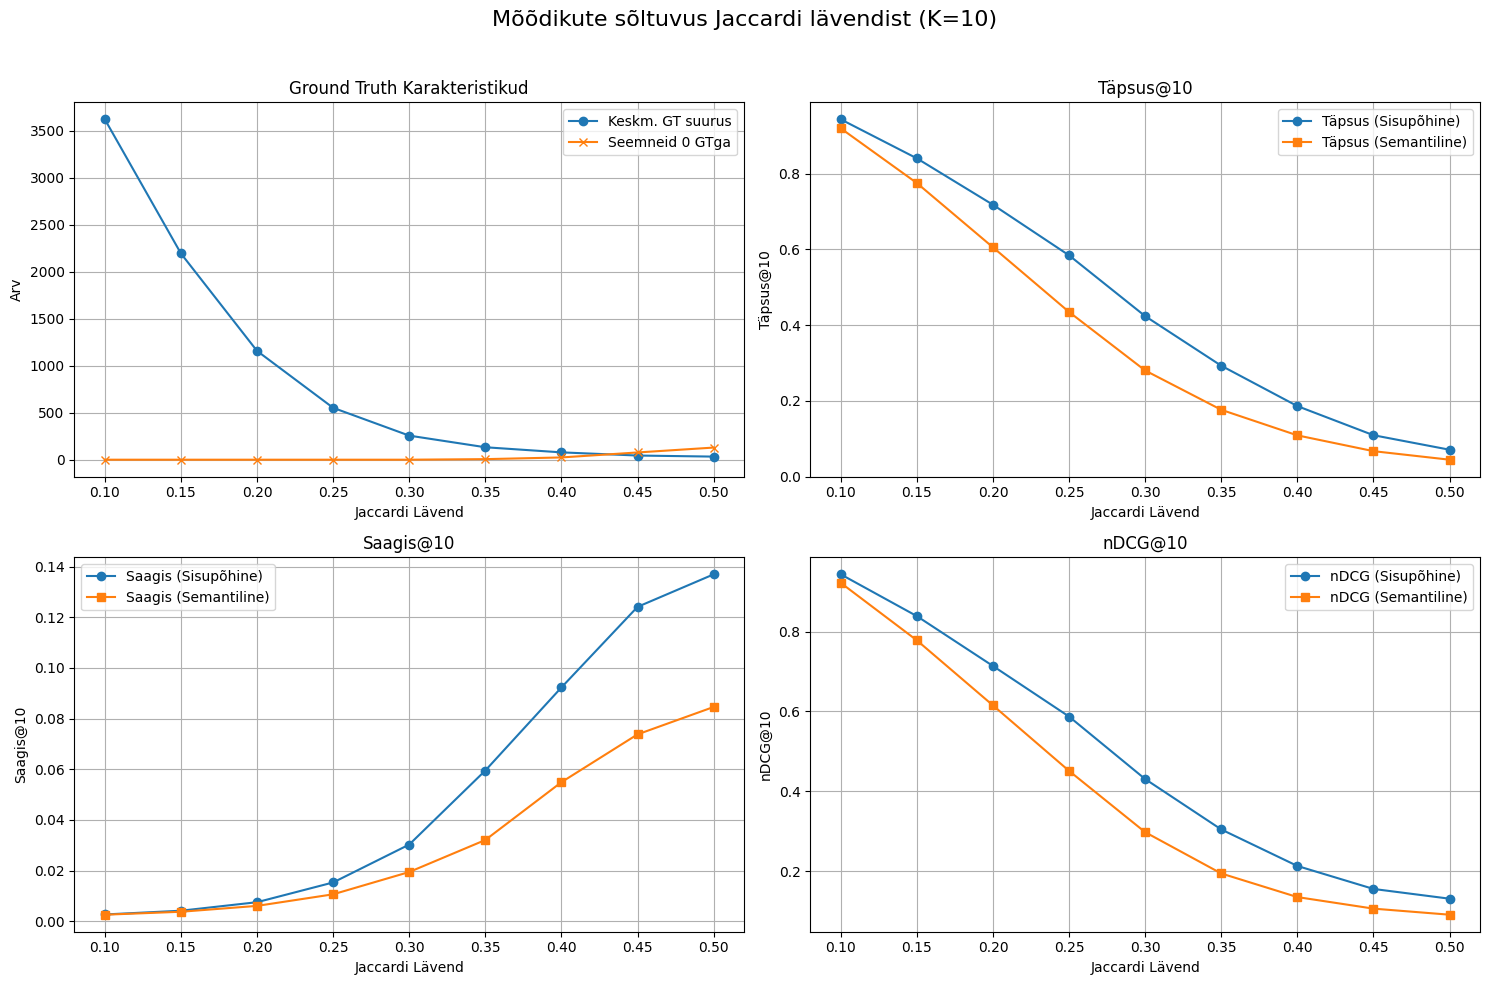

In [141]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle(f'Mõõdikute sõltuvus Jaccardi lävendist (K={K_FOR_THRESHOLD_SELECTION})', fontsize=16)

axs[0,0].plot(threshold_analysis_df['threshold'], threshold_analysis_df['avg_gt_size'], marker='o', label='Keskm. GT suurus')
axs[0,0].plot(threshold_analysis_df['threshold'], threshold_analysis_df['seeds_w_zero_gt'], marker='x', label='Seemneid 0 GTga')
axs[0,0].set_xlabel('Jaccardi Lävend')
axs[0,0].set_ylabel('Arv')
axs[0,0].set_title('Ground Truth Karakteristikud')
axs[0,0].legend()
axs[0,0].grid(True)

# Precision@K
axs[0,1].plot(threshold_analysis_df['threshold'], threshold_analysis_df['P_content'], marker='o', label='Täpsus (Sisupõhine)')
axs[0,1].plot(threshold_analysis_df['threshold'], threshold_analysis_df['P_semantic'], marker='s', label='Täpsus (Semantiline)')
axs[0,1].set_xlabel('Jaccardi Lävend')
axs[0,1].set_ylabel(f'Täpsus@{K_FOR_THRESHOLD_SELECTION}')
axs[0,1].set_title(f'Täpsus@{K_FOR_THRESHOLD_SELECTION}')
axs[0,1].legend()
axs[0,1].grid(True)

# Recall@K
axs[1,0].plot(threshold_analysis_df['threshold'], threshold_analysis_df['R_content'], marker='o', label='Saagis (Sisupõhine)')
axs[1,0].plot(threshold_analysis_df['threshold'], threshold_analysis_df['R_semantic'], marker='s', label='Saagis (Semantiline)')
axs[1,0].set_xlabel('Jaccardi Lävend')
axs[1,0].set_ylabel(f'Saagis@{K_FOR_THRESHOLD_SELECTION}')
axs[1,0].set_title(f'Saagis@{K_FOR_THRESHOLD_SELECTION}')
axs[1,0].legend()
axs[1,0].grid(True)

# nDCG@K
axs[1,1].plot(threshold_analysis_df['threshold'], threshold_analysis_df['N_content'], marker='o', label='nDCG (Sisupõhine)')
axs[1,1].plot(threshold_analysis_df['threshold'], threshold_analysis_df['N_semantic'], marker='s', label='nDCG (Semantiline)')
axs[1,1].set_xlabel('Jaccardi Lävend')
axs[1,1].set_ylabel(f'nDCG@{K_FOR_THRESHOLD_SELECTION}')
axs[1,1].set_title(f'nDCG@{K_FOR_THRESHOLD_SELECTION}')
axs[1,1].legend()
axs[1,1].grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## Lõplik testimine ja visualiseerimine

Genereerin lõplikku Ground Truth Jaccard Thresholdiga: 0.35...


Generating final GT:   0%|          | 0/501 [00:00<?, ?it/s]

Lõplik Ground Truth genereeritud. Keskmine GT suurus: 132.37. Seemneid 0 GT-ga: 6

Alustan mudelite testimist K väärtustega: [10, 20, 50, 100]


Testing K values:   0%|          | 0/4 [00:00<?, ?it/s]

K=10 valmis. Sisupõhine P@10: 0.2930, Semantiline P@10: 0.1766
K=20 valmis. Sisupõhine P@20: 0.2423, Semantiline P@20: 0.1426
K=50 valmis. Sisupõhine P@50: 0.1833, Semantiline P@50: 0.1058
K=100 valmis. Sisupõhine P@100: 0.1372, Semantiline P@100: 0.0841

Lõplikud tulemused (valitud Jaccard thresholdiga):
     K                Model  Precision    Recall      nDCG
0   10  Sisupõhine (TF-IDF)   0.293014  0.059515  0.304305
1   10  Semantiline (SBERT)   0.176647  0.032092  0.194065
2   20  Sisupõhine (TF-IDF)   0.242315  0.094721  0.265618
3   20  Semantiline (SBERT)   0.142615  0.051724  0.165430
4   50  Sisupõhine (TF-IDF)   0.183273  0.159935  0.226872
5   50  Semantiline (SBERT)   0.105828  0.090551  0.141152
6  100  Sisupõhine (TF-IDF)   0.137186  0.222230  0.216780
7  100  Semantiline (SBERT)   0.084132  0.136838  0.142462


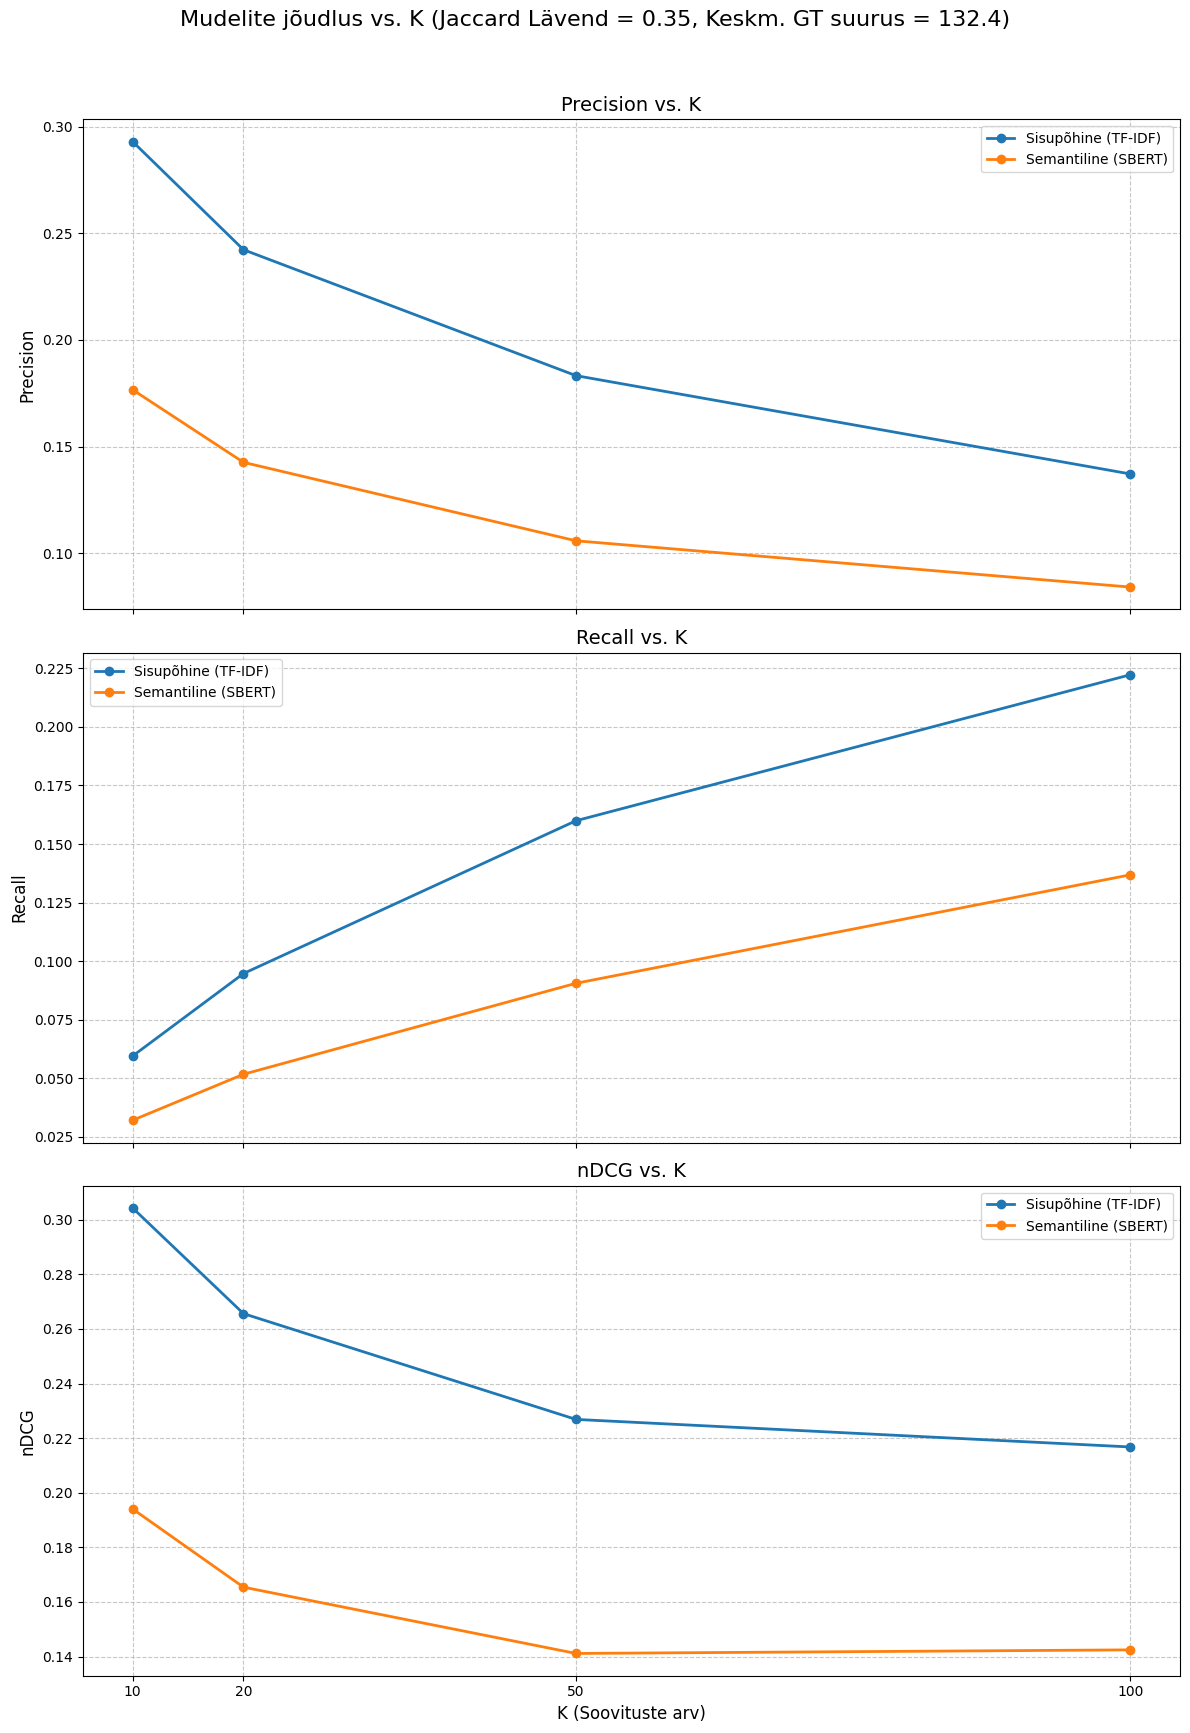


Tulemused Markdown tabelina (Pivot):
|   K |   ('Precision', 'Semantiline (SBERT)') |   ('Precision', 'Sisupõhine (TF-IDF)') |   ('Recall', 'Semantiline (SBERT)') |   ('Recall', 'Sisupõhine (TF-IDF)') |   ('nDCG', 'Semantiline (SBERT)') |   ('nDCG', 'Sisupõhine (TF-IDF)') |
|----:|---------------------------------------:|---------------------------------------:|------------------------------------:|------------------------------------:|----------------------------------:|----------------------------------:|
|  10 |                                 0.1766 |                                 0.293  |                              0.0321 |                              0.0595 |                            0.1941 |                            0.3043 |
|  20 |                                 0.1426 |                                 0.2423 |                              0.0517 |                              0.0947 |                            0.1654 |                            0.2656 |
|  50 |   

In [145]:
FINAL_JACCARD_THRESHOLD = 0.35
K_VALUES_TO_TEST = [10, 20, 50, 100]

if 'alpha' not in globals() or 'beta' not in globals():
    alpha = 0.6
    beta = 1 - alpha
    print(f"Alpha ja Beta defineeritud: alpha={alpha}, beta={beta}")

final_results_list = []

print(f"Genereerin lõplikku Ground Truth Jaccard Thresholdiga: {FINAL_JACCARD_THRESHOLD}...")
final_ground_truth = {}

for seed_idx in tqdm(seed_games.index, desc="Generating final GT"):
    # Veendu, et seed_idx on valid df DataFrame'i jaoks
    if seed_idx not in df.index:
        print(f"Hoiatus: Seemneindeks {seed_idx} ei leidu df DataFrame'is. Jätan vahele.")
        continue

    seed_game_row = df.loc[seed_idx]
    seed_appid = seed_game_row['appid']
    seed_features = seed_game_row['gt_feature_set']

    current_similar_appids = set()
    for other_idx, other_game_row in df.iterrows():
        if other_idx == seed_idx:
            continue

        other_features = other_game_row['gt_feature_set']
        similarity = jaccard_similarity(seed_features, other_features)

        if similarity >= FINAL_JACCARD_THRESHOLD:
            current_similar_appids.add(other_game_row['appid'])

    final_ground_truth[seed_appid] = current_similar_appids

avg_final_gt_size = np.mean([len(v) for v in final_ground_truth.values()]) if final_ground_truth and any(final_ground_truth.values()) else 0
seeds_with_zero_final_gt = sum(1 for v in final_ground_truth.values() if len(v) == 0) if final_ground_truth else len(seed_games)
print(f"Lõplik Ground Truth genereeritud. Keskmine GT suurus: {avg_final_gt_size:.2f}. Seemneid 0 GT-ga: {seeds_with_zero_final_gt}")

print(f"\nAlustan mudelite testimist K väärtustega: {K_VALUES_TO_TEST}")
for K_val in tqdm(K_VALUES_TO_TEST, desc="Testing K values"):
    recs_content_final = {}
    for seed_idx_ch in seed_games.index:
        if seed_idx_ch not in df.index: continue
        df_recs_ch = content_hybrid(seed_idx_ch, K_val, alpha, beta)
        recs_content_final[seed_idx_ch] = df_recs_ch['appid'].tolist()

    p_c, r_c, n_c = calculate_metrics_for_model(recs_content_final, final_ground_truth, K_val, df, seed_games)
    final_results_list.append({'K': K_val, 'Model': 'Sisupõhine (TF-IDF)',
                               'Precision': p_c, 'Recall': r_c, 'nDCG': n_c})

    recs_semantic_final = {}
    for seed_idx_sh in seed_games.index:
        if seed_idx_sh not in df.index: continue
        df_recs_sh = hybrid_recs(seed_idx_sh, K_val, alpha, beta)
        recs_semantic_final[seed_idx_sh] = df_recs_sh['appid'].tolist()

    p_s, r_s, n_s = calculate_metrics_for_model(recs_semantic_final, final_ground_truth, K_val, df, seed_games)
    final_results_list.append({'K': K_val, 'Model': 'Semantiline (SBERT)',
                               'Precision': p_s, 'Recall': r_s, 'nDCG': n_s})

    print(f"K={K_val} valmis. Sisupõhine P@{K_val}: {p_c:.4f}, Semantiline P@{K_val}: {p_s:.4f}")

final_results_df = pd.DataFrame(final_results_list)

print("\nLõplikud tulemused (valitud Jaccard thresholdiga):")
print(final_results_df)

metrics_to_plot = ['Precision', 'Recall', 'nDCG']
model_names = final_results_df['Model'].unique()
num_metrics = len(metrics_to_plot)
fig, axs = plt.subplots(num_metrics, 1, figsize=(12, 6 * num_metrics), sharex=True)
if num_metrics == 1:
    axs = [axs]

fig.suptitle(f'Mudelite jõudlus vs. K (Jaccard Lävend = {FINAL_JACCARD_THRESHOLD}, Keskm. GT suurus = {avg_final_gt_size:.1f})',
             fontsize=16, y=0.99)

for i, metric in enumerate(metrics_to_plot):
    ax = axs[i]
    for model_name in model_names:
        model_data = final_results_df[final_results_df['Model'] == model_name]
        ax.plot(model_data['K'], model_data[metric], marker='o', linestyle='-', linewidth=2, label=model_name)

    ax.set_ylabel(metric, fontsize=12)
    ax.set_title(f'{metric} vs. K', fontsize=14)
    ax.legend(fontsize=10)
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.set_xticks(K_VALUES_TO_TEST)


axs[-1].set_xlabel('K (Soovituste arv)', fontsize=12)
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()

print("\nTulemused Markdown tabelina (Pivot):")
pivot_table = final_results_df.pivot_table(index='K', columns='Model', values=['Precision', 'Recall', 'nDCG'])
for col in pivot_table.columns:
    pivot_table[col] = pivot_table[col].apply(lambda x: f"{x:.4f}")
print(pivot_table.to_markdown())